<a href="https://colab.research.google.com/github/siddharthk27/Neural-Circuit-Policies/blob/main/Mixed%20Memory.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip3 install ncps torch "ale-py==0.7.4" "ray[rllib]==2.1.0" "gym[atari,accept-rom-license]==0.23.1"


In [6]:
import torch
import numpy as np
import random

# Set seeds for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

In [7]:
import torch.nn as nn
import torch.nn.functional as F

class ConvBlock(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(4, 64, 5, padding=2, stride=2)
        self.conv2 = nn.Conv2d(64, 128, 5, padding=2, stride=2)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 128, 5, padding=2, stride=2)
        self.conv4 = nn.Conv2d(128, 256, 5, padding=2, stride=2)
        self.bn4 = nn.BatchNorm2d(256)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = F.relu(self.bn4(self.conv4(x)))
        x = x.mean((-1, -2))  # Global average pooling
        return x

In [21]:
from ncps.torch import CfC

class ConvCfC(nn.Module):
    def __init__(self, n_actions):
        super().__init__()
        self.conv_block = ConvBlock()
        self.rnn = CfC(256, 64, batch_first=True, mixed_memory = True, proj_size=n_actions)

    def forward(self, x, hx=None):
        batch_size = x.size(0)
        seq_len = x.size(1)
        # Merge time and batch dimension into a single one (because the Conv layers require this)
        x = x.view(batch_size * seq_len, *x.shape[2:])
        x = self.conv_block(x)  # apply conv block to merged data
        # Separate time and batch dimension again
        x = x.view(batch_size, seq_len, *x.shape[1:])
        x, hx = self.rnn(x, hx)  # hx is the hidden state of the RNN
        return x, hx

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [9]:
from tqdm import tqdm

In [10]:
import gym
import ale_py
from ray.rllib.env.wrappers.atari_wrappers import wrap_deepmind

env = gym.make("ALE/Breakout-v5")
# We need to wrap the environment with the Deepmind helper functions
env = wrap_deepmind(env)

/usr/local/lib/python3.10/dist-packages/flax/configurations.py:42: DeprecationWarning: jax.config.define_bool_state is deprecated. Please use other libraries for configuration instead.
  return jax_config.define_bool_state('flax_' + name, default, help)
/usr/local/lib/python3.10/dist-packages/flax/linen/activation.py:36: DeprecationWarning: jax.nn.normalize is deprecated. Use jax.nn.standardize instead.
  from jax.nn import normalize
/usr/local/lib/python3.10/dist-packages/tensorflow_probability/python/__init__.py:57: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if (distutils.version.LooseVersion(tf.__version__) <
/usr/local/lib/python3.10/dist-packages/gym/utils/seeding.py:138: DeprecationWarning: WARN: Function `hash_seed(seed, max_bytes)` is marked as deprecated and will be removed in the future. 
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/utils/seeding.py:175: DeprecationWarning: WARN: Function `_bigint_from_bytes(by

In [24]:
import torch
from torch.utils.data import Dataset
import torch.optim as optim
from ncps.datasets.torch import AtariCloningDataset

train_ds = AtariCloningDataset("breakout", split="train")
val_ds = AtariCloningDataset("breakout", split="val")
trainloader = torch.utils.data.DataLoader(
    train_ds, batch_size=32, num_workers=4, shuffle=True
)
valloader = torch.utils.data.DataLoader(val_ds, batch_size=32, num_workers=4)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [25]:
def run_closed_loop(model, env, num_episodes=None):
    obs = env.reset()
    device = next(model.parameters()).device
    hx = None  # Hidden state of the RNN
    returns = []
    total_reward = 0
    with torch.no_grad():
        while True:
            # PyTorch require channel first images -> transpose data
            obs = np.transpose(obs, [2, 0, 1]).astype(np.float32) / 255.0
            # add batch and time dimension (with a single element in each)
            obs = torch.from_numpy(obs).unsqueeze(0).unsqueeze(0).to(device)
            pred, hx = model(obs, hx)
            # remove time and batch dimension -> then argmax
            action = pred.squeeze(0).squeeze(0).argmax().item()
            obs, r, done, _ = env.step(action)
            total_reward += r
            if done:
                obs = env.reset()
                hx = None  # Reset hidden state of the RNN
                returns.append(total_reward)
                total_reward = 0
                if num_episodes is not None:
                    # Count down the number of episodes
                    num_episodes = num_episodes - 1
                    if num_episodes == 0:
                        return returns

In [26]:
def train_one_epoch(model, criterion, optimizer, trainloader):
    running_loss = 0.0
    pbar = tqdm(total=len(trainloader))
    model.train()
    device = next(model.parameters()).device  # get device the model is located on
    for i, (inputs, labels) in enumerate(trainloader):
        inputs = inputs.to(device)  # move data to same device as the model
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs, hx = model(inputs)
        labels = labels.view(-1, *labels.shape[2:])  # flatten
        outputs = outputs.reshape(-1, *outputs.shape[2:])  # flatten
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        pbar.set_description(f"loss={running_loss / (i + 1):0.4g}")
        pbar.update(1)
    pbar.close()

def eval(model, valloader):
    losses, accs = [], []
    model.eval()
    device = next(model.parameters()).device  # get device the model is located on
    with torch.no_grad():
        for inputs, labels in valloader:
            inputs = inputs.to(device)  # move data to same device as the model
            labels = labels.to(device)

            outputs, _ = model(inputs)
            outputs = outputs.reshape(-1, *outputs.shape[2:])  # flatten
            labels = labels.view(-1, *labels.shape[2:])  # flatten
            loss = criterion(outputs, labels)
            acc = (outputs.argmax(-1) == labels).float().mean()
            losses.append(loss.item())
            accs.append(acc.item())
    return np.mean(losses), np.mean(accs)

In [27]:
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score ,precision_score, recall_score


In [28]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ConvCfC(n_actions=env.action_space.n).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Initialize lists to store training loss per epoch
val_losses = []
val_accuracies = []
f1_scores = []
precision_scores = []
recall_scores = []

for epoch in range(3):  # loop over the dataset multiple times


    train_one_epoch(model, criterion, optimizer, trainloader)

    # Evaluate model on the validation set
    val_loss, val_acc = eval(model, valloader)

    # Calculate F1 score
    true_labels, predicted_labels = [], []
    model.eval()
    with torch.no_grad():
        for inputs, labels in valloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs, _ = model(inputs)
            predicted_labels.extend(outputs.argmax(-1).view(-1).cpu().numpy())
            true_labels.extend(labels.view(-1).cpu().numpy())

    f1 = f1_score(true_labels, predicted_labels, average='weighted')
    precision = precision_score(true_labels, predicted_labels, average='weighted')
    recall = recall_score(true_labels, predicted_labels, average='weighted')

    f1_scores.append(f1)
    precision_scores.append(precision)
    recall_scores.append(recall)

    # Store values for plotting
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}, val_loss={val_loss:0.4g}, val_acc={100*val_acc:0.2f}%, F1 Score={f1:0.4g}, Recall={recall:0.4g}, Precision={precision:0.4g}")

    # Apply model in closed-loop environment
    returns = run_closed_loop(model, env, num_episodes=10)
    print(f"Mean return {np.mean(returns)} (n={len(returns)})")



loss=0.3864: 100%|██████████| 938/938 [08:42<00:00,  1.80it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1, val_loss=0.5428, val_acc=84.48%, F1 Score=0.8013, Recall=0.8446, Precision=0.8424
Mean return 1.9 (n=10)


  0%|          | 0/938 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
loss=0.2234: 100%|██████████| 938/938 [08:40<00:00,  1.80it/s]


Epoch 2, val_loss=0.2064, val_acc=92.61%, F1 Score=0.9242, Recall=0.926, Precision=0.9231
Mean return 40.2 (n=10)


  0%|          | 0/938 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
loss=0.1812: 100%|██████████| 938/938 [08:42<00:00,  1.79it/s]


Epoch 3, val_loss=0.8873, val_acc=67.06%, F1 Score=0.7073, Recall=0.6703, Precision=0.8665
Mean return 1.9 (n=10)


<ipython-input-29-d1b294af98f9>:19: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 3, 3)
<ipython-input-29-d1b294af98f9>:27: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()


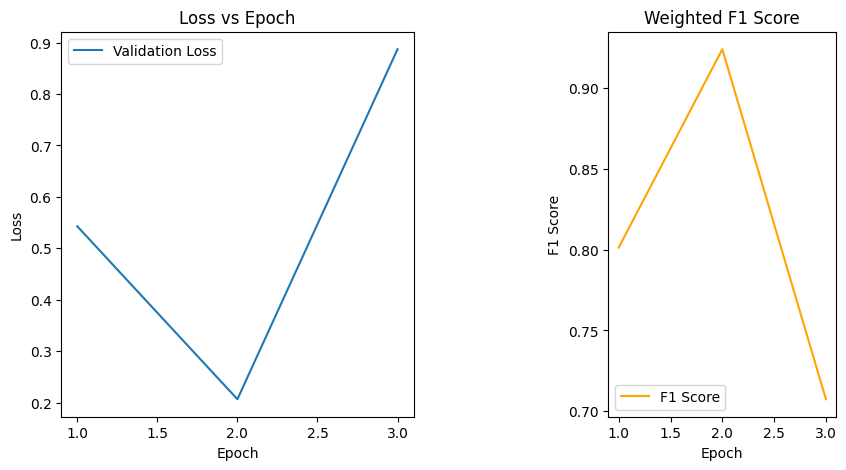

In [29]:
# Plotting
epochs = range(1, len(val_losses) + 1)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, val_losses, label='Validation Loss')
plt.title('Loss vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(epochs, f1_scores, label='F1 Score', color='orange')
plt.title('Weighted F1 Score')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend()


plt.tight_layout()
plt.show()

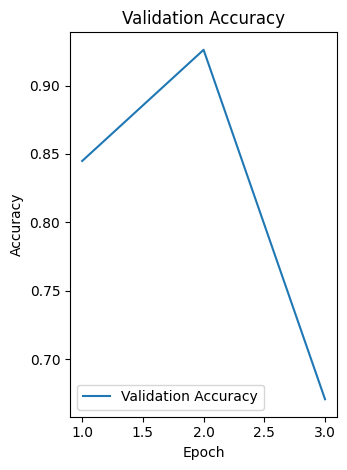

In [30]:
plt.subplot(1, 2, 2)
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Visualize Atari game and play endlessly
env = gym.make("ALE/Breakout-v5", render_mode="human")
env = wrap_deepmind(env)
run_closed_loop(model, env)